

# Investor Risk Tolerance and Robo advisors

The goal of this case study is to build a machine learning model to predict the risk tolerance or risk aversion of an investor, and use the model in a robo-advisor dashboard.


<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, the predicted variable
is the “true” risk tolerance of an individual and the predictor variables are demographic, financial and behavioral attributes of an individual

For this case study the data used is from survey of Consumer Finances which is conducted by the Federal Reserve
Board in 2007 (pre-crisis) and 2009 (post-crisis). The data source is : 
https://www.federalreserve.gov/econres/scf_2009p.htm

<a id='1'></a>
# 2. Loading the data and python packages

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import copy 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

In [2]:
# load dataset
dataset0 = pd.read_excel('SCFP2009panel.xlsx')

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [33]:
dataset = dataset0.copy()
dataset.shape

(19285, 515)

<a id='2'></a>
## 3. Data Preparation and Feature Selection

The dataset from "Survey of Consumer Finances" contains the Household's demographics, net worth, financial and non-financial assets for the same demographics in 2007 (pre-crisis) and 2009(post-crisis). 

The predicted variable is the "true" risk tolerance. There are different ways of getting the "true" risk tolerance. The idea and the purpose of this case study is to come up with an approach to solve the behavioral finance problem using machine learning. 

The steps to compute the predicted variables are as follows: 

1) Compute the Risky asset and the riskless assets for all the individuals in the survey data. Risky and riskless assets are defined as follows: 
* **Risky assets** is investments in mutual funds, stocks, bonds, commodities, and
real estate, and an estimate of human capital. 
* **Risk Free Assets**: checking and savings balances,certificates of deposit, and other cash balances and equivalents.

2) We take the ratio of risky assets to total assets of an investor and consider that as a measure of risk tolerance of an investor. From the data of SCF, we have the data of risky and riskless assets for the individuals for 2007 and 2009. We use this data and normalise the risky assets with the stock price of 2007 vs. 2009 to get risk tolerance. 

* **Risk Tolerance**  just defined as the ratio of Risky Asset to Riskless Assets normalised with the average S&P500 of 2007 vs 2009. 
Average S&P500 in 2007: 1478
Average S&P500 in 2009: 948

3) In a lot of literature, an intelligent investor is the one who doesn't change its risk tolerance during the change in the market. So, we consider the investors who change their risk tolerance by less than 10% between 2007 and 2009 as the intelligent investors. Ofcourse this is a qualitative judgement and is subject to change. However, as mentioned before more than being accurate and precise the purpose of theis case study is to demonstrate the usage of the machine learning and provide a machine learning based framework in behavioral finance and portfolio management which can be further leveraged for more detailed analysis. 

In [34]:
#Average SP500 during 2007 and 2009
Average_SP500_2007=1478
Average_SP500_2009=948

#Risk Tolerance 2007
dataset['RiskFree07']= dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07'] 
dataset['RT07'] = dataset['Risky07']/(dataset['Risky07']+dataset['RiskFree07'])

#Risk Tolerance 2009
dataset['RiskFree09']= dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09'] 
dataset['RT09'] = dataset['Risky09']/(dataset['Risky09']+dataset['RiskFree09'])*\
                (Average_SP500_2009/Average_SP500_2007)

In [35]:
dataset.head()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I,RiskFree07,Risky07,RT07,RiskFree09,Risky09,RT09
0,1,11,11668.134198,47,3,12,2,1,0,2,...,0.0,93.125197,270.403054,57,7994.813847,0.0,0.0,16000,17000,0.330422
1,1,12,11823.456494,47,3,12,2,1,0,2,...,0.0,93.125197,249.593620,57,7994.813847,0.0,0.0,19000,18000,0.312036
2,1,13,11913.228354,47,3,12,2,1,0,2,...,0.0,93.125197,209.233358,57,7984.457871,0.0,0.0,13000,12000,0.307876
3,1,14,11929.394266,47,3,12,2,1,0,2,...,0.0,93.125197,209.273158,57,7984.457871,0.0,0.0,25000,13000,0.219429
4,1,15,11917.722907,47,3,12,2,1,0,2,...,0.0,93.125197,232.690767,57,7994.813847,0.0,0.0,17000,12000,0.265410


In [40]:
clm = dataset.columns.values.tolist() 
clm.sort()
clm

['ACTBUS07',
 'ACTBUS09',
 'ADJM107',
 'ADJM109',
 'ADJM207',
 'ADJM209',
 'AGE07',
 'AGE09',
 'AGEALL07',
 'AGEALL09',
 'AGECL07',
 'AGECL09',
 'AGEFT07',
 'AGEFT09',
 'ANNUIT07',
 'ANNUIT09',
 'ANYPEN07',
 'ANYPEN09',
 'APPLIED07',
 'APPLIED09',
 'ASSET07',
 'ASSET09',
 'ASSETCAT07',
 'ASSETCAT09',
 'ASSETDIF',
 'ASSETPCT',
 'BCALL07',
 'BCALL09',
 'BDONT07',
 'BDONT09',
 'BFINPLAN07',
 'BFINPLAN09',
 'BFINPRO07',
 'BFINPRO09',
 'BFRIENDWORK07',
 'BFRIENDWORK09',
 'BINTERNET07',
 'BINTERNET09',
 'BMAGZNEWS07',
 'BMAGZNEWS09',
 'BMAILADTV07',
 'BMAILADTV09',
 'BOND07',
 'BOND09',
 'BONDDIF',
 'BONDPCT',
 'BOTHER07',
 'BOTHER09',
 'BPLANCJ07',
 'BPLANCJ09',
 'BSELF07',
 'BSELF09',
 'BSHOPGRDL07',
 'BSHOPGRDL09',
 'BSHOPMODR07',
 'BSHOPMODR09',
 'BSHOPNONE07',
 'BSHOPNONE09',
 'BUS07',
 'BUS09',
 'BUSDIF',
 'BUSPCT',
 'BUSSEFARMINC07',
 'BUSSEFARMINC09',
 'BUSSEFARMINCDIF',
 'BUSSEFARMINCPCT',
 'BUSVEH07',
 'BUSVEH09',
 'CALL07',
 'CALL09',
 'CALLDIF',
 'CALLPCT',
 'CASHLI07',
 'CASHLI0

Let us compute the percentage change in risk tolerance between 2007 and 2009. 

In [41]:
dataset['PercentageChange'] = np.abs(dataset['RT09']/dataset['RT07']-1)

Checking for the rows with null or nan values and removing them.

In [42]:
#Checking for any null values 
print('Null Values =',dataset.isnull().values.any())

Null Values = True


In [43]:
# Drop the rows containing NA
dataset=dataset.dropna(axis=0)

dataset=dataset[~dataset.isin([np.nan, np.inf, -np.inf]).any(1)]

#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


Let us plot the risk tolerance of 2007 and 2009. 

<AxesSubplot:xlabel='RT07'>

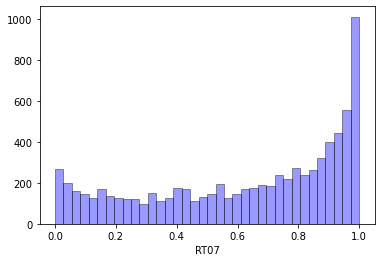

In [44]:
sns.distplot(dataset['RT07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

Looking at the risk tolerance of 2007, we see that a significant number of individuals had risk tolerance close to one.Meaning the investment ws more skewed towards the risky assets as compared to the riskless assets. We will comere this so the risk tolerance in 2009.

<AxesSubplot:xlabel='RT09'>

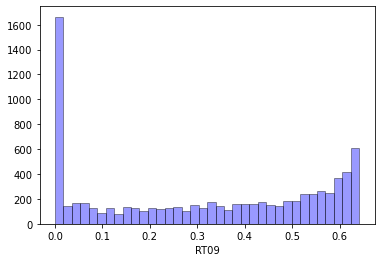

In [45]:
sns.distplot(dataset['RT09'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

The behavior of the individuals reversed in 2009 after crisis and majority of the investment was in risk free assets. Overall risk tolerance decreased. 
In the next step we only take the intelligent investors whose risk tolerance change between 2007 and 2009 was less than 10%

In [46]:
dataset = dataset[dataset['PercentageChange']<=.1]

The true risk tolerance is assigned as the average risk tolerance of these intelligent investors between 2007 and 2009. This is the predicted variable for this case study. The purpose would be to predict the true risk tolerance of an individuals given the demographic, financial and willingness to take risk related features. 

In [47]:
dataset['TrueRiskTolerance'] = (dataset['RT07'] + dataset['RT09'])/2

Drop other labels which might not be needed for the prediction. 

In [48]:
dataset.drop(labels=['RT07', 'RT09'], axis=1, inplace=True)
dataset.drop(labels=['PercentageChange'], axis=1, inplace=True)

In order to filter the features further we do the following:
1. Check the description in the Data Dictionary (https://www.federalreserve.gov/econres/files/codebk2009p.txt, https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbkh01.htm)and only keep the features that are relevant
The description is as follows: 


* AGE: The age of the household reference person.
* EDUC: There are 4 education categories, where 1 represents no high school and 4 represents college degree.
* MARRIED: It represents marital status. There are two categories where 1 represents married and 2 represents unmarried. 
* OCCAT1: It represents occupation category. 1 represents managerial category and 4 represents unemployed.
* KIDS: It represents number of kids. 
* NETWORTH: Total net worth of household, 2019 dollars: the difference between assets and debt. See definitions of assets and debt for further clarification. 
* INCOME: Total income of household in 2019 dollars.
* RISK: It represents the willingness to take risk on a scale of 1 to 4, where 1 represents highest level of willingness to take risk. 

2. Keep only the intuitive factors as of 2007 only and remove all the intermediate features and features related to 2009, as the variables of 2007 are the only ones required for predicting the risk tolerance.


In [51]:
keep_list2 = ['AGE07','EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07','RISK07','NETWORTH07','TrueRiskTolerance'
]

drop_list2 = [col for col in dataset.columns if col not in keep_list2]

dataset.drop(labels=drop_list2, axis=1, inplace=True)

Let us look at the correlation among the features.

<AxesSubplot:title={'center':'Correlation Matrix'}>

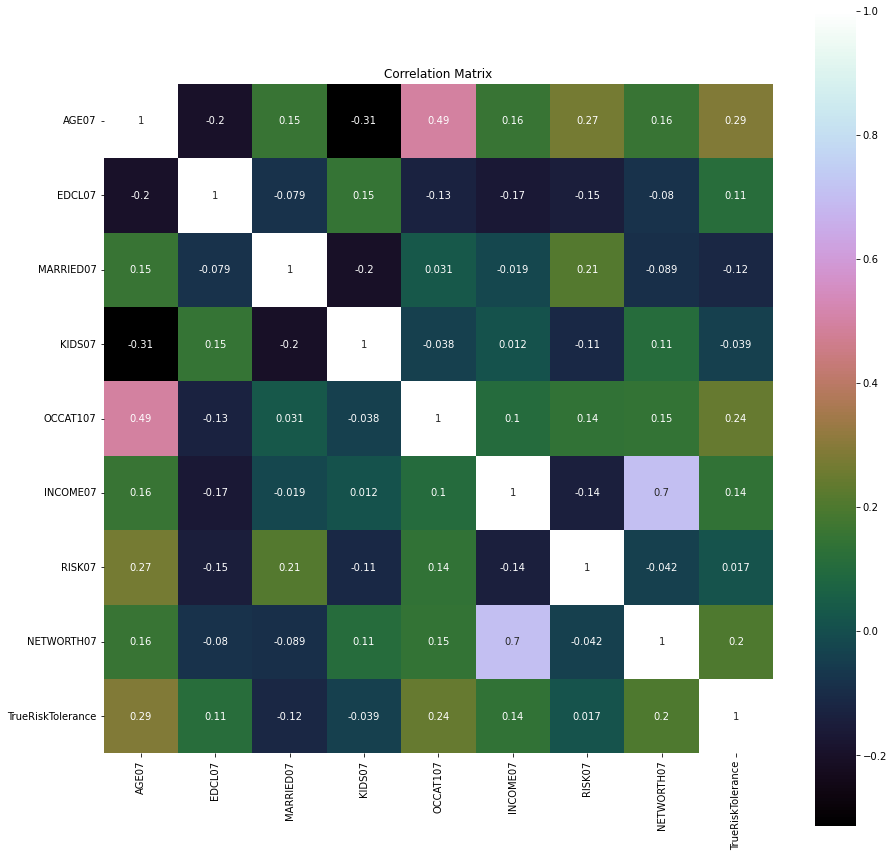

In [52]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

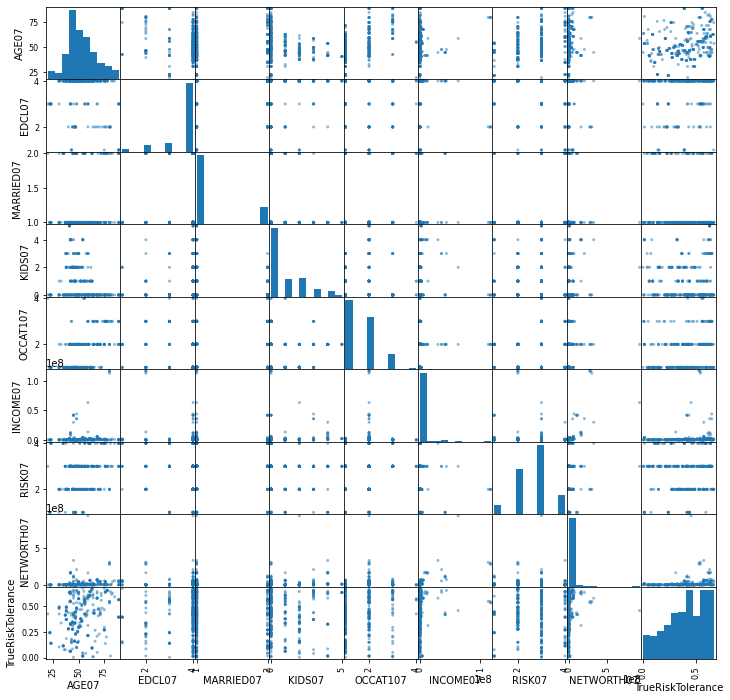

In [53]:
# Scatterplot Matrix
from pandas.plotting import scatter_matrix
plt.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
plt.show()

#### Conclusions
* Networth and income are positively correlated with the risk tolerance.
* With more number of kids and marriage the risk tolerance decreases. 
* As the willingness to take risk decreases the risk tolerance decreases. 
* With age there is a positive relationship of the risk tolerance. 

As per the paper "Does Risk Tolerance Decrease With Age?(Hui Wang1,Sherman Hanna)", Relative risk aversion decreases as people age (i.e., the proportion of net wealth invested in risky assets increases as people age) when other variables are held constant.Therefore, risk tolerance increases with age. 

So, in summary all the variables and their relationship with risk tolerance seems intuitive. 

<a id='4'></a>
# 4. Evaluate Algorithms and Models

Let us evaluate the algorithms and the models. 

Performing a train and test split in this step. 

In [55]:
# split out validation dataset for the end
Y= dataset["TrueRiskTolerance"]
X = dataset.loc[:, dataset.columns != 'TrueRiskTolerance']
# scaler = StandardScaler().fit(X)
# rescaledX = scaler.transform(X)
validation_size = 0.2
seed = 3
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [56]:
# test options for regression
num_folds = 10
#scoring = 'neg_mean_squared_error'
#scoring ='neg_mean_absolute_error'
scoring = 'r2'

### Regression Models

In [57]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
#Neural Network
#models.append(('MLP', MLPRegressor()))
#Ensable Models 
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

### K-folds cross validation

In [59]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.102704 (0.179297)
LASSO: -0.041555 (0.109033)
EN: -0.047729 (0.108990)
KNN: -0.424571 (0.141433)
CART: -0.518595 (0.228111)
SVR: -0.127821 (0.100887)
ABR: -0.406310 (0.152057)
GBR: -0.620934 (0.140847)
RFR: -0.705648 (0.092700)
ETR: -0.696681 (0.152831)


### Algorithm comparison

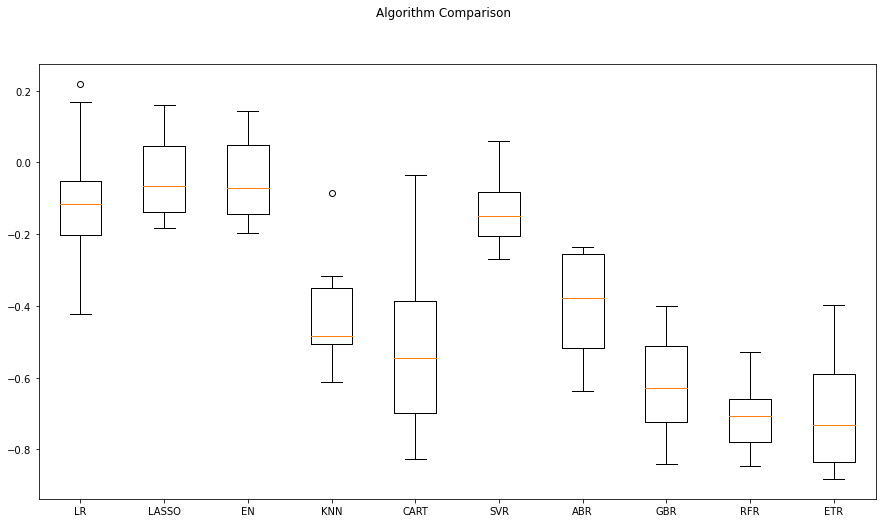

In [60]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

The non linear models perform better than the linear models, which means that a non linear relationship between the risk tolerance and the difference variables use to predict it. Given random forest regression is one of the best methods, we use it for further grid search. 

<a id='5'></a>
# 5. Model Tuning and Grid Search

Given that the Random Forest is the best model, Grid Search is performed on Random Forest.

In [63]:
# 8. Grid search : RandomForestRegressor 
'''
n_estimators : integer, optional (default=10)
    The number of trees in the forest.
'''
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.714401 using {'n_estimators': 350}
0.708087 (0.101995) with: {'n_estimators': 50}
0.705508 (0.106294) with: {'n_estimators': 100}
0.711251 (0.103664) with: {'n_estimators': 150}
0.713714 (0.102605) with: {'n_estimators': 200}
0.713056 (0.111333) with: {'n_estimators': 250}
0.706844 (0.101558) with: {'n_estimators': 300}
0.714401 (0.113783) with: {'n_estimators': 350}
0.705193 (0.102894) with: {'n_estimators': 400}


Random forest with number of estimators 350, is the best model after grid search. 

<a id='6'></a>
# 6. Finalise the Model

Finalize Model with best parameters found during tuning step.

In [65]:
# prepare model
model = RandomForestRegressor(n_estimators = 350)
model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=350)

In [66]:
from sklearn.metrics import r2_score
predictions_train = model.predict(X_train)
print(r2_score(Y_train, predictions_train))

0.9640879424345347


In [67]:
# estimate accuracy on validation set
# transform the validation dataset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(X_validation)
print(mean_squared_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))

0.007344612587074819
0.7748525878267789


From the mean square error and R2 shown above for the test set, the results look good. 

Looking at the details above Random forest be worthy of further study.
Let us look into the Feature Importance of the RF model

[0.22754456 0.02751228 0.01318735 0.04267116 0.02494554 0.23047866
 0.05116039 0.38250006]


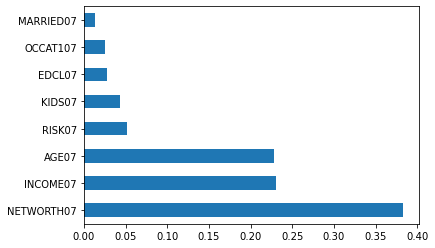

In [68]:
import pandas as pd
import numpy as np
model = RandomForestRegressor(n_estimators= 200,n_jobs=-1)
model.fit(X_train,Y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

From the chart above, income and networth followed by age and willingness to take risk are the key variables to decide the risk tolerance. These variables have been considered as the key variables to model the risk tolerance across several literature. 

<a id='6.3'></a>
## 6.3. Save Model for Later Use

In [69]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model2007.sav'
dump(model, open(filename, 'wb'))

In [70]:
# load the model from disk
loaded_model = load(open(filename, 'rb'))
# estimate accuracy on validation set
predictions = loaded_model.predict(X_validation)
result = mean_squared_error(Y_validation, predictions)
print(r2_score(Y_validation, predictions))
print(result)

0.7608106407524602
0.00780267986057176


__Conclusion__:

We showed that machine learning models might be able to objectively
analyze the behavior of different investors in a changing market and attribute these
changes to variables involved in determining risk appetite. With an increase in the
volume of investor’s data and availability of rich machine learning infrastructure,
such models might prove to be more useful.

We saw that there is a non-linear relationship between the variables and the risk tolerance. Income and net worth followed by age and willingness to take risk are the key variables to decide the risk tolerance. These variables have been considered as the key variables to model the risk tolerance across several literature.
